### 07. 앙상블 학습과 랜덤 포레스트
- - -
- **앙상블학습(Ensemble learning)** = 일련의 예측기
- **앙상블방법(Ensemble method)** = 앙상블 학습 알고리즘<br>

In [4]:
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### 7.1 투표 기반 분류기
**각기 다른 분류기로 다양한 분류기 만들기**
- 직접투표(hard votinng) : 각 분류기의 예측을 모아서 가장 많이 선택된 클래스 예측<br>
    ㄴ 각 분류기가 약한 학습기일지라도 충분히 많고 다양하면 강한 학습기가 됨(단, 모든 분류기가 독립이고 오차에 상관관계가 없어야함)
- 간접투표(soft voting) : 각 분류기의 예측을 평균내어 확률이 가장 높은 클래스를 예측 >> 직접보다 성능 우수<br>
    ㄴ 단, SVC 클래스 확률을 제공하지 않기 때문에 probability매개변수를 True 지정해야함<br>
- predict_proba() = 모델의 클래스 확률 예측 >> 모든 분류기가 메서드 사용가능하면 = 간접투표 가능 


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],
    voting='hard') #voting hard = 직접 / soft = 간접
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.904


결과처럼 Voting이 다른 모델보다 우세함

### 7.2 배깅과 페이스팅
**무작위로 훈련 서브셋 구성해서 다양한 분류기 만들기**
- 배깅(Bagging, bootstrap appregating) : 훈련세트에서 중복을 허용하여 샘플링 하는 방식 >> 한 예측기를 위해 훈련 샘플 여러번 샘플링 가능
- 페이스팅(Pasting) : 중복을 허용하지 않고 샘플링을 하는 방식
- 수집함수(분류) : 통계적 최빈값(Statistical mode, like hard voting)<br>
수집함수(회귀) : 평균


개별 예측기 = 원본 훈련세트로 훈련시킨 것보다 더 편향 됨 >> 수집 함수 통과시 편향과 분산 모두 감소<br>
앙상블의 결과 >> 원본데이터셋으로 하나의 예측기 훈련 시킬 때보다 분산만 줄어듦(편향은 비슷)

### 7.2.1 사이킷런의 배깅과 페이스팅

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42) 
    #페이스팅 사용시 bootstrap=False지정 / n-jobs = 훈련및예측에 사용할 CPU 코어 수 지정 -1 지정시 가용한 모든 코어 사용
    #Bagging의 경우, 기반 분류기가 클래스 확률 추정이 가능하면 자동으로 간접투표 방식으로 진행
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [9]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [10]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [11]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

그림 저장: decision_tree_without_and_with_bagging_plot


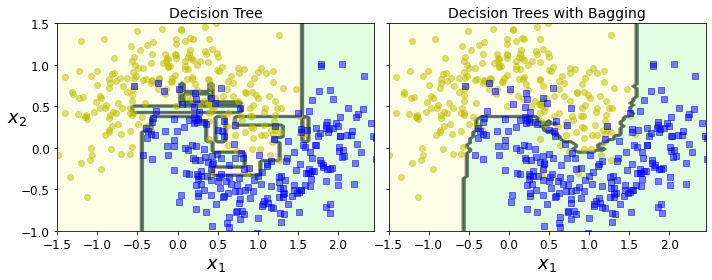

In [12]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

일반 결정트리보다 배깅 결정트리가 훨씬 일반화가 잘됨 >> 편향은 그대로 / 분산만 줄임
<br><br>
부트스트래핑 = 각 예측기가 학습하는 서브셋에 다양성 증가 = 배깅이 페이스팅 보다 편향이 높음 대신 앙상블의 분산 감소(예측기 간의 상관관계 줄어듦)<br>
= 일반적으로는 배깅 선호(but 둘 다 해봐야 한다)

### 7.2.2 obb 평가
배깅 사용 = 훈련세트의 크기만큼인 m개 샘플 선택 >> 평균적으로 각 예측기에 훈련 샘플의 63%정도만 샘플링 된다는것
- oob(out-of-bag) : 나머지 37% 샘플 >> 예측기마다 다름<br>
예측기 훈련 중 oob는 사용되지 않음 >> 별도의 검증세트 없이 obb로 평가 가능 = 앙상블의 평가는 각 예측기의 oob 평가의 평균<br>

In [15]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train,y_train)
bag_clf.oob_score_

0.904

In [16]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

oob 정확도와 테스트 정확도가 유사<br>
obb_decision_function_ 메서드로 변수 확인도 가능(훈련 샘플의 클래스 확률, 첫번쨰 훈련 샘플이 양성 확률 65.4%/음성 34.5%)

In [17]:
bag_clf.oob_decision_function_

array([[0.34545455, 0.65454545],
       [0.30769231, 0.69230769],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.10326087, 0.89673913],
       [0.4009901 , 0.5990099 ],
       [0.01886792, 0.98113208],
       [0.97826087, 0.02173913],
       [1.        , 0.        ],
       [0.72774869, 0.27225131],
       [0.        , 1.        ],
       [0.75595238, 0.24404762],
       [0.89759036, 0.10240964],
       [0.93922652, 0.06077348],
       [0.07608696, 0.92391304],
       [0.00520833, 0.99479167],
       [0.98445596, 0.01554404],
       [0.95454545, 0.04545455],
       [0.99375   , 0.00625   ],
       [0.02702703, 0.97297297],
       [0.28877005, 0.71122995],
       [0.92783505, 0.07216495],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.645     , 0.355     ],
       [0.

### 7.3 랜덤 패치와 랜덤 서브스페이스
